In [18]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils import data
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats


train_data=pd.read_csv("./traincsv/train.csv")
test_data=pd.read_csv("./testcsv/test.csv")

train_data.shape,test_data.shape

device='cuda:0' if torch.cuda.is_available else 'cpu';
print(device)

cuda:0


In [19]:
[i for i in train_data.columns if i not in test_data.columns]

['Sold Price']

In [20]:
train_data.iloc[:4]

,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,...,"Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,...,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,...,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,...,"Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230,CA


In [21]:
train_data.columns,test_data.columns

(Index(['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built',
        'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms',
        'Full bathrooms', 'Total interior livable area', 'Total spaces',
        'Garage spaces', 'Region', 'Elementary School',
        'Elementary School Score', 'Elementary School Distance',
        'Middle School', 'Middle School Score', 'Middle School Distance',
        'High School', 'High School Score', 'High School Distance', 'Flooring',
        'Heating features', 'Cooling features', 'Appliances included',
        'Laundry features', 'Parking features', 'Tax assessed value',
        'Annual tax amount', 'Listed On', 'Listed Price', 'Last Sold On',
        'Last Sold Price', 'City', 'Zip', 'State'],
       dtype='object'),
 Index(['Id', 'Address', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling',
        'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
        'Total interior livable area', 'Total spaces', 'Garage spac

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

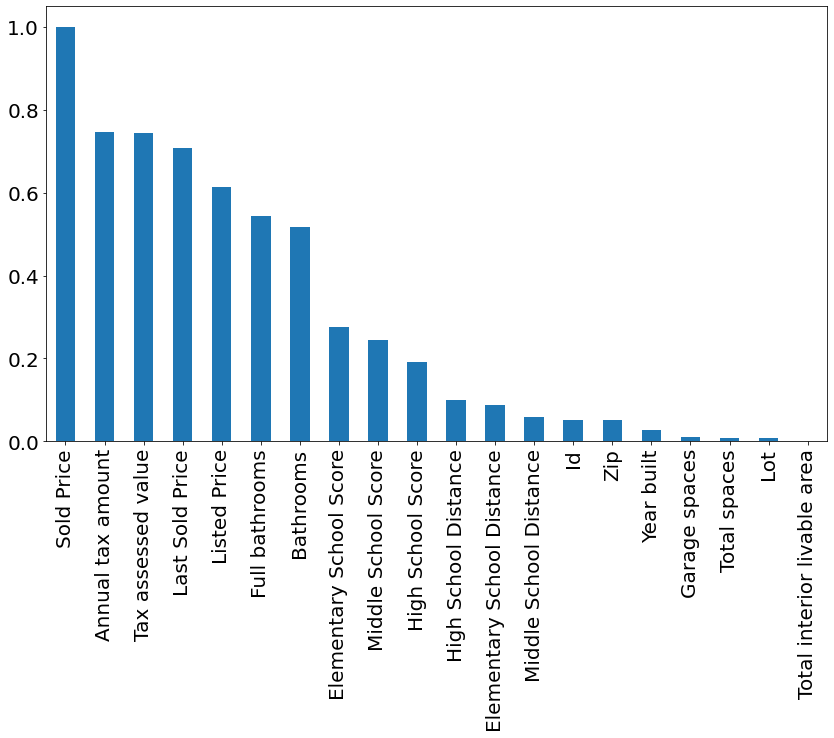

In [22]:
fig=plt.figure(figsize=(14,8))
abs(train_data.corr()['Sold Price']).sort_values(ascending=False).plot.bar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [23]:
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:-1]))
all_features = all_features.loc[:, ["Year built","Type", "Lot", "Bathrooms", "Full bathrooms", "Total spaces", "High School Score","Tax assessed value", "Annual tax amount", "Listed Price", "Last Sold Price", "Zip"]]
all_features

,Year built,Type,Lot,Bathrooms,Full bathrooms,Total spaces,High School Score,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,Zip
0,1969.0,SingleFamily,1.0,0.0,NaN,0.0,8.0,886486.0,12580.0,4198000.0,NaN,94022
1,1926.0,SingleFamily,4047.0,2.0,2.0,1.0,2.0,505000.0,6253.0,525000.0,328000.0,90047
2,1958.0,SingleFamily,9147.0,3.0,1.0,0.0,NaN,49627.0,468.0,180000.0,NaN,95375
3,1947.0,SingleFamily,NaN,3.0,3.0,0.0,8.0,1775000.0,20787.0,1895000.0,1500000.0,90230
4,NaN,VacantLand,NaN,NaN,NaN,NaN,6.0,NaN,NaN,1595000.0,900000.0,93432
...,...,...,...,...,...,...,...,...,...,...,...,...
31621,2019.0,SingleFamily,NaN,6.0,NaN,0.0,7.0,4819317.0,53342.0,8500000.0,895500.0,95991
31622,1970.0,SingleFamily,1626.0,2.0,1.0,2.0,NaN,296819.0,3195.0,330000.0,328000.0,92057
31623,NaN,VacantLand,NaN,NaN,NaN,NaN,5.0,NaN,NaN,443000.0,NaN,91941
31624,1984.0,Townhouse,NaN,3.0,2.0,2.0,6.0,334277.0,4032.0,445000.0,470000.0,92139


In [24]:
np.any(all_features.isnull())

True

In [25]:
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
numeric_features
all_features[numeric_features]=all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std())
)
all_features[numeric_features]=all_features[numeric_features].fillna(0)
# len(pd.unique(all_features.loc[:,'Type']))

In [26]:
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(79065, 186)

In [27]:
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32,device=device)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels=torch.tensor(train_data['Sold Price'].values.reshape(-1,1),dtype=torch.float32,device=device)
train_features.shape,test_features.shape,train_labels.shape

(torch.Size([47439, 186]), torch.Size([31626, 186]), torch.Size([47439, 1]))

In [28]:
loss=nn.MSELoss()
in_features=train_features.shape[1]
def get_net():
    net=nn.Sequential(
        nn.Linear(in_features,32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,1)
    )
    return net

In [29]:
def log_rmse(net,features,labels):
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [30]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [31]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size) # 将训练数据打包成batch_size大小，并可迭代取出
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad() # 梯度清零
            l = loss(net(X), y) # 计算损失，注意：pytorch会自动将向量转换成标量，以便反向传播计算导数
            l.backward() # 反向传播：计算梯度
            optimizer.step() # 更新参数
        train_ls.append(log_rmse(net, train_features, train_labels)) # 将训练的对数rmse保存下来，以便返回
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels)) # 将测试的对数rmse保存下来，以便返回
    return train_ls, test_ls

In [32]:
def get_k_fold_data(k, i, X, y): # i表示第几折
    assert k > 1
    fold_size = X.shape[0] // k # 分成k份,每折的大小
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) # slice() 函数实现切片对象，主要用在切片操作函数里的参数传递。
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


In [33]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k): # 做k次
        data = get_k_fold_data(k, i, X_train, y_train) # 获取训练集和验证集
        net = get_net() # 模型
        
        if torch.cuda.is_available():
            net = net.cuda()
            # data = data.cuda()
        
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size) # 得到损失，注意：data传入的是列表
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0: # 画第1折训练的曲线
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k


In [34]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 0.9, 512
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')


KeyboardInterrupt: 

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv(r'../data/kaggle_house_pred/submission.csv', index=False) # 将预测的房价结果保存下来

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)
